In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import (
    ExponentialLR,
    CosineAnnealingLR,
    CyclicLR,
    MultiStepLR,
    ReduceLROnPlateau,
    ConstantLR,
)
import sys, os
import tqdm
import matplotlib.pyplot as plt

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname("src"))))
from src.CumstomCosineAnnealingwarmRestarts import CosineAnnealingWarmUpRestarts
from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet_CIFAR, MyResNet34
from src.Earlystopper import EarlyStopper
from src.LogViewer import LogViewer

In [2]:
"""Dataset selection"""
# DATASET = "CIFAR10"
# DATASET = "CIFAR100"
DATASET = "ImageNet2012"

"""Dataset parameters"""
BATCH = 256
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True

"""optimizer parameters"""
optim_list = [
    # "Adam",
    # "Adam_decay",
    # "SGD",
    # "SGD_nasterov",
    # "AdamW",
    # "AdamW_amsgrad",
    "NAdam",
]
print_pad_len_optim = max([len(i) for i in optim_list])

scheduler_list = [
    # "ExponentialLR",
    # "MultiStepLR",
    "ReduceLROnPlateau",
    # "CosineAnnealingLR",
    # "CosineAnnealingWarmUpRestarts8",
    # "CosineAnnealingWarmUpRestarts10",
    # "CosineAnnealingWarmUpRestarts14",
    # "ConstantLR",
    # "CycleLR",
]
print_pad_len_schduler = max([len(i) for i in scheduler_list])

"""Learning rate scheduler parameters"""
NUM_EPOCHS = 100

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = NUM_EPOCHS

In [3]:
class Single_model:
    def __init__(self, optimizer_name, schduler_name, device="cuda") -> None:
        if DATASET == "ImageNet2012":
            self.file_name = f"MyResNet34_{BATCH}_{optimizer_name}_{schduler_name}"
            self.model = MyResNet34(num_classes=1000, Downsample_option="B").to(device)
        elif DATASET == "CIFAR10":
            self.file_name = f"MyResNet32_{BATCH}_{optimizer_name}_{schduler_name}"
            self.model = MyResNet_CIFAR(num_classes=10, num_layer_factor=5).to(device)

        self.optim_name = optimizer_name
        self.scheduler_name = schduler_name

        """define loss function"""
        self.criterion = nn.CrossEntropyLoss()

        """define optimizer"""
        if optimizer_name == "Adam":
            self.optimizer = torch.optim.Adam(self.model.parameters())
        elif optimizer_name == "Adam_decay":
            self.optimizer = torch.optim.Adam(
                self.model.parameters(), weight_decay=1e-4
            )
        elif optimizer_name == "SGD":
            self.optimizer = torch.optim.SGD(
                self.model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4
            )
        elif optimizer_name == "SGD_nasterov":
            self.optimizer = torch.optim.SGD(
                self.model.parameters(),
                lr=0.1,
                momentum=0.9,
                weight_decay=1e-4,
                nesterov=True,
            )
        elif optimizer_name == "AdamW":
            self.optimizer = torch.optim.AdamW(
                self.model.parameters(), weight_decay=1e-4
            )
        elif optimizer_name == "AdamW_amsgrad":
            self.optimizer = torch.optim.AdamW(
                self.model.parameters(), weight_decay=1e-4, amsgrad=True
            )
        elif optimizer_name == "NAdam":
            self.optimizer = torch.optim.NAdam(
                self.model.parameters(), weight_decay=1e-4
            )

        """define earlystopper"""
        self.earlystopper = EarlyStopper(
            patience=EARLYSTOPPINGPATIENCE, model=self.model, file_name=self.file_name
        )

        """define learning rate scheduler"""
        if schduler_name == "ExponentialLR":
            self.scheduler = ExponentialLR(self.optimizer, gamma=0.95)
        elif schduler_name == "MultiStepLR":
            self.scheduler = MultiStepLR(self.optimizer, milestones=[50, 75], gamma=0.1)
        elif schduler_name == "ReduceLROnPlateau":
            self.scheduler = ReduceLROnPlateau(
                self.optimizer, patience=10, factor=0.1, cooldown=40
            )
        elif schduler_name == "CosineAnnealingLR":
            """
            - T_max : half of single pariod
            - eta_min : min_lr
            """
            self.scheduler = CosineAnnealingLR(self.optimizer, T_max=20, eta_min=0.001)
        elif schduler_name == "CosineAnnealingWarmUpRestarts":
            """
            초기 lr = near zero여야함.
            - T_0 : single period, 14로 했다가, 10도 테스트 해봄.
            - T_mult : period multiply factor. 2면 다음부터 주기 2배욈
            - eta_max : max_lr. 처음 튀어 오를 lr
            - T_up : warmup period. 튀어오르는데 필요한 epochs.
            - gamma : eta_max decay factor.
            """

            if schduler_name[:29] == "CosineAnnealingWarmUpRestarts":
                self.optimizer.param_groups[0]["lr"] = 1e-8
                if schduler_name[2:4] == "8":
                    _T_0 = 8
                elif schduler_name[2:4] == "10":
                    _T_0 = 10
                elif schduler_name[2:4] == "14":
                    _T_0 = 12
                else:
                    raise NotImplementedError

                if optimizer_name == "NAdam":
                    self.scheduler = CosineAnnealingWarmUpRestarts(
                        self.optimizer,
                        T_0=_T_0,
                        T_mult=2,
                        eta_max=0.002,
                        T_up=2,
                        gamma=0.5,
                    )
                elif optimizer_name[:3] == "SGD":
                    self.scheduler = CosineAnnealingWarmUpRestarts(
                        self.optimizer,
                        T_0=_T_0,
                        T_mult=2,
                        eta_max=0.1,
                        T_up=2,
                        gamma=0.5,
                    )
                elif optimizer_name[:4] == "Adam":
                    self.scheduler = CosineAnnealingWarmUpRestarts(
                        self.optimizer,
                        T_0=_T_0,
                        T_mult=2,
                        eta_max=0.001,
                        T_up=2,
                        gamma=0.5,
                    )
        elif schduler_name == "ConstantLR":
            self.scheduler = ConstantLR(
                self.optimizer, factor=1, total_iters=NUM_EPOCHS
            )
            pass

        """define scaler"""
        self.scaler = torch.cuda.amp.GradScaler(enabled=True)


# %%
class Single_training(Single_model):
    def __init__(self, optimizer_name, schduler_name, device="cuda"):
        super().__init__(
            optimizer_name=optimizer_name, schduler_name=schduler_name, device=device
        )

        self.device = device
        """loading log file"""
        if os.path.exists(self.file_name + ".pth.tar"):
            # Read checkpoint as desired, e.g.,
            checkpoint = torch.load(
                self.file_name + ".pth.tar",
                map_location=lambda storage, loc: storage.cuda(self.device),
            )
            # self.model.load_state_dict(checkpoint["model"])
            self.optimizer.load_state_dict(checkpoint["optimizer"])
            # self.scaler.load_state_dict(checkpoint["scaler"])
            # self.scheduler.load_state_dict(checkpoint["scheduler"])
            # self.earlystopper.load_state_dict(checkpoint["earlystopper"])
            self.logs = checkpoint["logs"]

            print("Suceessfully loaded the All setting and Log file.")
            print(self.file_name)
            print(f"Current epoch is {len(self.logs['train_loss'])}")
            print(f"Current learning rate: {self.optimizer.param_groups[0]['lr']}")
        else:
            # Create a dictionary to store the variables
            train_loss = []
            train_acc = []
            eval_loss = []
            valid_acc = []
            test_loss = []
            test_acc = []
            lr_log = []
            self.logs = {
                "train_loss": train_loss,
                "train_acc": train_acc,
                "valid_loss": eval_loss,
                "valid_acc": valid_acc,
                "test_loss": test_loss,
                "test_acc": test_acc,
                "lr_log": lr_log,
            }
            print("File does not exist. Created a new log.")

        self.train_loss = 0.0
        self.running_loss = 0.0
        self.running_corrects = 0
        self.running_total = 0
        self.train_acc = 0

        self.test_loss = 0.0
        self.test_corrects = 0
        self.test_total = 0
        self.test_acc = 0.0

    def set_mode_train(self):
        self.running_loss = 0.0
        self.running_corrects = 0
        self.running_total = 0
        self.model.train()

    def set_mode_test(self):
        self.test_loss = 0.0
        self.test_corrects = 0
        self.test_total = 0
        self.model.eval()

In [4]:
each_trainings = []
for optim in optim_list:
    for scheduler in scheduler_list:
        each_trainings.append(Single_training(optim, scheduler))
        


Suceessfully loaded the All setting and Log file.
MyResNet34_256_NAdam_ReduceLROnPlateau
Current epoch is 31
Current learning rate: 0.002


In [5]:
each_trainings = list()
# for optim_name in optim_list:
#     for schduler_name in scheduler_list:
#         each_trainings.append(
#             Single_training(
#                 optimizer_name=optim_name, schduler_name=schduler_name, device="cuda"
#             )
#         )
#         print("-" * 50)
each_trainings.append(
    Single_training(
        optimizer_name="NAdam", schduler_name="ReduceLROnPlateau", device="cuda"
    )
)
print("-" * 50)
each_trainings.append(
    Single_training(optimizer_name="NAdam", schduler_name="MultiStepLR", device="cuda")
)
print("-" * 50)
each_trainings.append(
    Single_training(optimizer_name="SGD", schduler_name="MultiStepLR", device="cuda")
)
print("-" * 50)

Suceessfully loaded the All setting and Log file.
MyResNet34_256_NAdam_ReduceLROnPlateau
Current epoch is 31
Current learning rate: 0.002
--------------------------------------------------
Suceessfully loaded the All setting and Log file.
MyResNet34_256_NAdam_MultiStepLR
Current epoch is 31
Current learning rate: 0.0002
--------------------------------------------------
Suceessfully loaded the All setting and Log file.
MyResNet34_256_SGD_MultiStepLR
Current epoch is 31
Current learning rate: 0.010000000000000002
--------------------------------------------------


In [6]:
# # Create a figure and axis
# fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20, 15))

# # Plot the train_loss values from each object
# for training in each_trainings:
#     if training.optimizer.__class__.__name__ == "SGD":
#     # ax[0][0].plot(training.logs["train_loss"], label=training.optim_name, linestyle='-', linewidth=2)
#     # ax[0][1].plot(training.logs["train_acc"], label=training.optim_name, linestyle='--', linewidth=2)
#     # ax[1][0].plot(training.logs["test_loss"], label=training.optim_name, linestyle=':', linewidth=2)
#     # ax[1][1].plot(training.logs["test_loss"], label=training.optim_name, linestyle='-.', linewidth=2)
#         ax[0][0].plot(training.logs["train_loss"], label=training.optim_name+"_"+training.scheduler_name)
#         ax[0][1].plot(training.logs["train_acc"], label=training.optim_name+"_"+training.scheduler_name)
#         ax[1][0].plot(training.logs["test_loss"], label=training.optim_name+"_"+training.scheduler_name)
#         ax[1][1].plot(training.logs["test_acc"], label=training.optim_name+"_"+training.scheduler_name)

# # Set labels and title
# ax[0][0].set_xlabel("Epoch")
# ax[0][0].set_ylabel("Train Loss")
# ax[0][0].set_title("Train Loss")
# ax[0][0].legend()

# ax[0][1].set_xlabel("Epoch")
# ax[0][1].set_ylabel("Train Acc")
# ax[0][1].set_title("Train Acc")
# ax[0][1].legend()

# ax[1][0].set_xlabel("Epoch")
# ax[1][0].set_ylabel("Test Loss")
# ax[1][0].set_title("Test Loss")
# ax[1][0].legend()

# ax[1][1].set_xlabel("Epoch")
# ax[1][1].set_ylabel("Test Acc")
# ax[1][1].set_title("Test Acc")
# ax[1][1].legend()

# # Add a legend


# # Show the plot
# plt.show()
# plt.savefig(f"all_SGD.png")

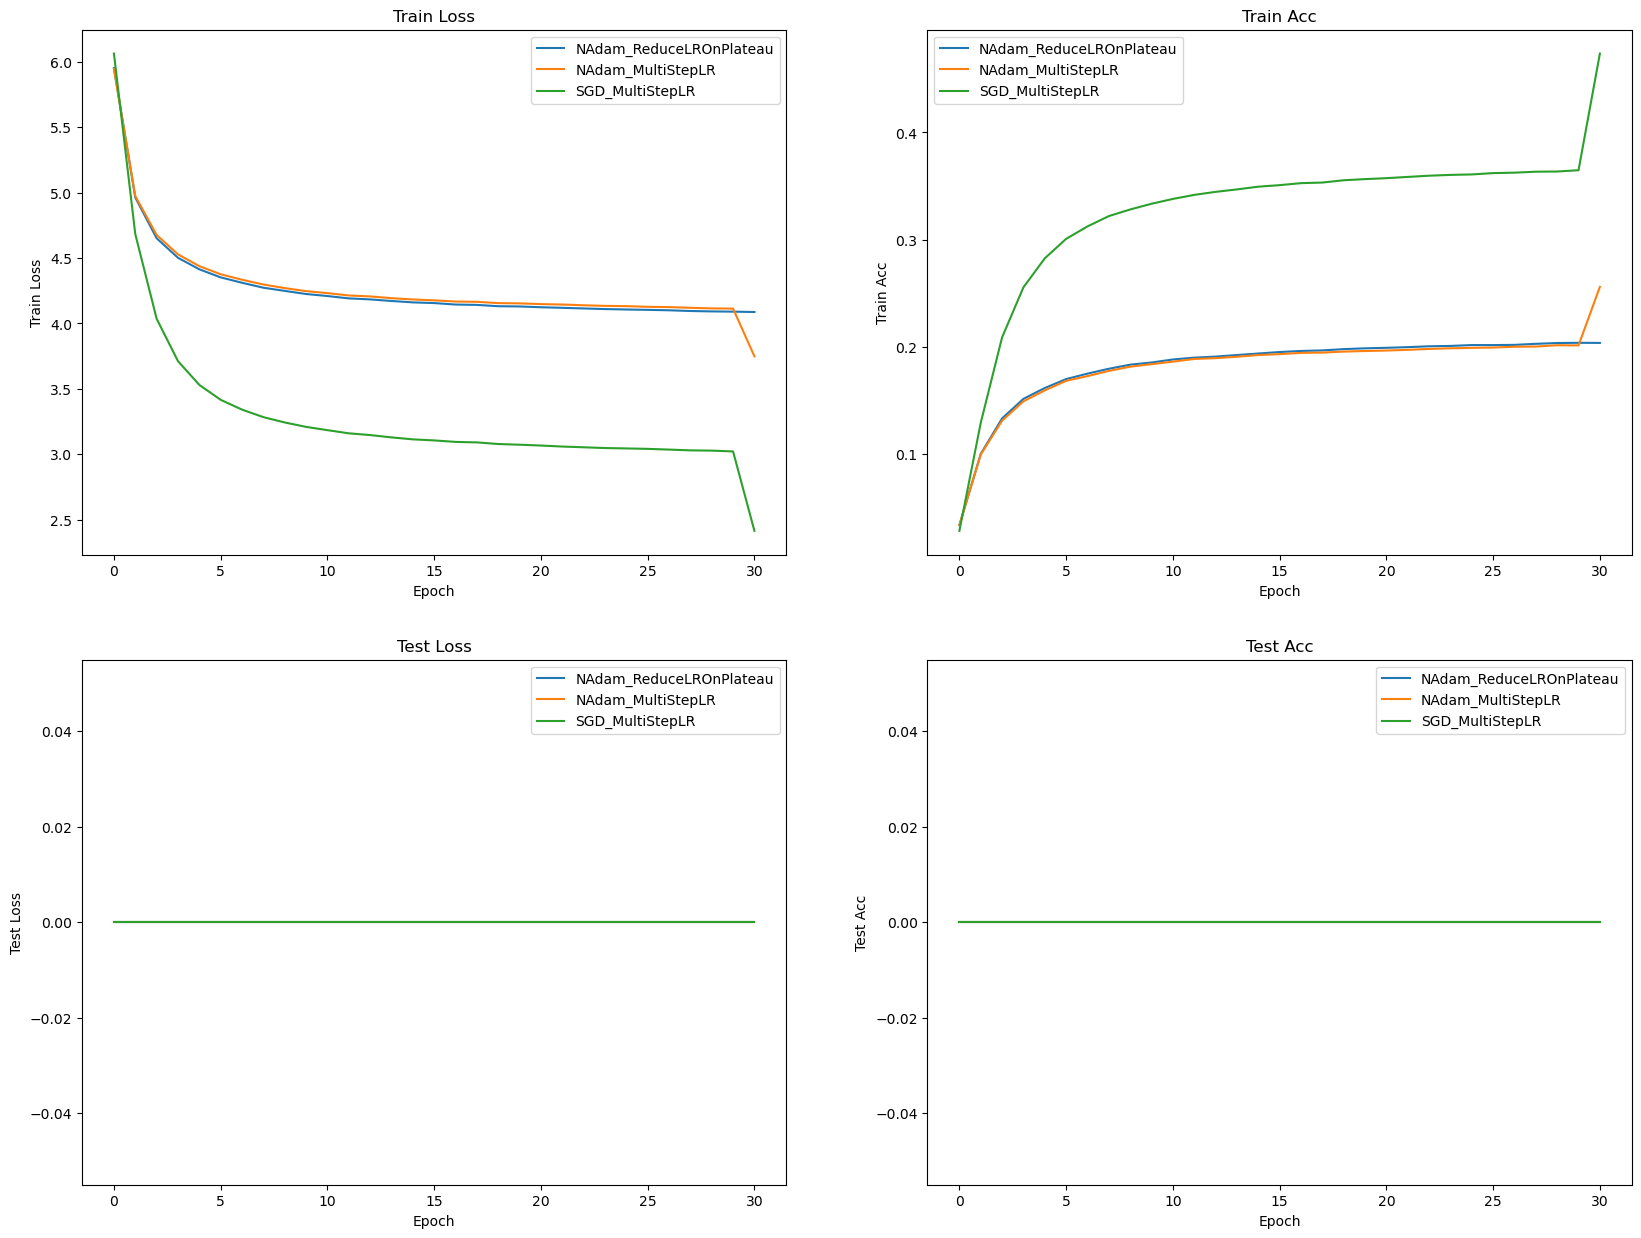

<Figure size 640x480 with 0 Axes>

In [7]:
# Create a figure and axis
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20, 15))

# Plot the train_loss values from each object
for training in each_trainings:
    # if training.optimizer.__class__.__name__ == "NAdam":
        # ax[0][0].plot(training.logs["train_loss"], label=training.optim_name, linestyle='-', linewidth=2)
        # ax[0][1].plot(training.logs["train_acc"], label=training.optim_name, linestyle='--', linewidth=2)
        # ax[1][0].plot(training.logs["test_loss"], label=training.optim_name, linestyle=':', linewidth=2)
        # ax[1][1].plot(training.logs["test_loss"], label=training.optim_name, linestyle='-.', linewidth=2)
    ax[0][0].plot(
        training.logs["train_loss"],
        label=training.optim_name + "_" + training.scheduler_name,
    )
    ax[0][1].plot(
        training.logs["train_acc"],
        label=training.optim_name + "_" + training.scheduler_name,
    )
    ax[1][0].plot(
        training.logs["test_loss"],
        label=training.optim_name + "_" + training.scheduler_name,
    )
    ax[1][1].plot(
        training.logs["test_acc"],
        label=training.optim_name + "_" + training.scheduler_name,
    )

# Set labels and title
ax[0][0].set_xlabel("Epoch")
ax[0][0].set_ylabel("Train Loss")
ax[0][0].set_title("Train Loss")
ax[0][0].legend()

ax[0][1].set_xlabel("Epoch")
ax[0][1].set_ylabel("Train Acc")
ax[0][1].set_title("Train Acc")
ax[0][1].legend()

ax[1][0].set_xlabel("Epoch")
ax[1][0].set_ylabel("Test Loss")
ax[1][0].set_title("Test Loss")
ax[1][0].legend()

ax[1][1].set_xlabel("Epoch")
ax[1][1].set_ylabel("Test Acc")
ax[1][1].set_title("Test Acc")
ax[1][1].legend()

# Add a legend


# Show the plot
plt.show()
plt.savefig(f"all.png")

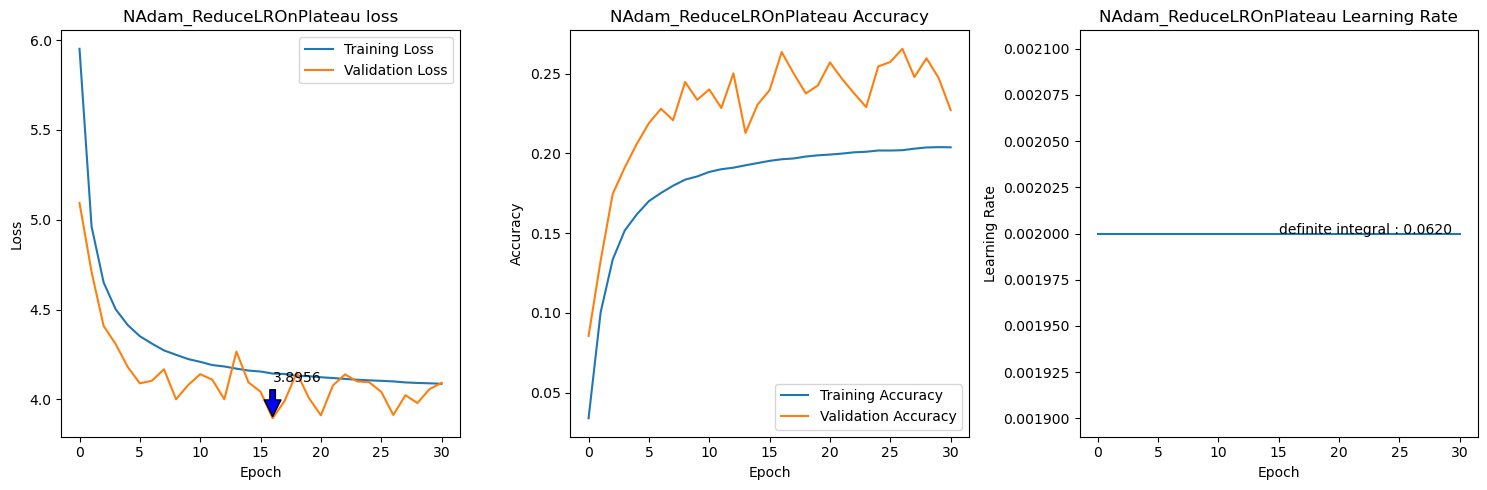

NAdam_ReduceLROnPlateau
0
0
10
now_lr:  0.002
1 epoch: train_loss=5.9514, train_acc=0.0339, valid_loss=5.0939, valid_acc=0.0855, lr=0.0020
2 epoch: train_loss=4.9627, train_acc=0.1003, valid_loss=4.7097, valid_acc=0.1327, lr=0.0020
3 epoch: train_loss=4.6510, train_acc=0.1334, valid_loss=4.4091, valid_acc=0.1745, lr=0.0020
4 epoch: train_loss=4.5016, train_acc=0.1516, valid_loss=4.3080, valid_acc=0.1912, lr=0.0020
5 epoch: train_loss=4.4138, train_acc=0.1617, valid_loss=4.1806, valid_acc=0.2060, lr=0.0020
6 epoch: train_loss=4.3520, train_acc=0.1701, valid_loss=4.0897, valid_acc=0.2190, lr=0.0020
7 epoch: train_loss=4.3108, train_acc=0.1752, valid_loss=4.1044, valid_acc=0.2280, lr=0.0020
8 epoch: train_loss=4.2730, train_acc=0.1797, valid_loss=4.1683, valid_acc=0.2208, lr=0.0020
9 epoch: train_loss=4.2487, train_acc=0.1835, valid_loss=4.0011, valid_acc=0.2448, lr=0.0020
10 epoch: train_loss=4.2249, train_acc=0.1855, valid_loss=4.0802, valid_acc=0.2336, lr=0.0020
11 epoch: train_loss=4.

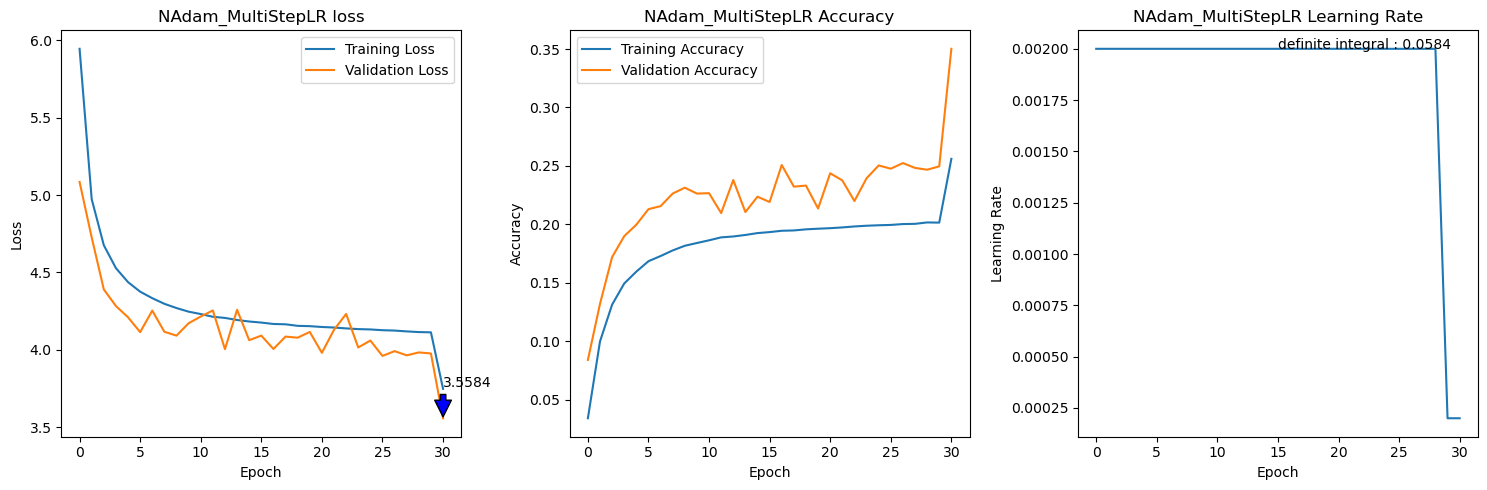

NAdam_MultiStepLR
now_lr:  0.0002
1 epoch: train_loss=5.9449, train_acc=0.0340, valid_loss=5.0849, valid_acc=0.0839, lr=0.0020
2 epoch: train_loss=4.9737, train_acc=0.0997, valid_loss=4.7265, valid_acc=0.1319, lr=0.0020
3 epoch: train_loss=4.6762, train_acc=0.1313, valid_loss=4.3907, valid_acc=0.1719, lr=0.0020
4 epoch: train_loss=4.5279, train_acc=0.1493, valid_loss=4.2832, valid_acc=0.1899, lr=0.0020
5 epoch: train_loss=4.4377, train_acc=0.1595, valid_loss=4.2105, valid_acc=0.1997, lr=0.0020
6 epoch: train_loss=4.3759, train_acc=0.1684, valid_loss=4.1146, valid_acc=0.2130, lr=0.0020
7 epoch: train_loss=4.3340, train_acc=0.1728, valid_loss=4.2538, valid_acc=0.2156, lr=0.0020
8 epoch: train_loss=4.2976, train_acc=0.1777, valid_loss=4.1170, valid_acc=0.2263, lr=0.0020
9 epoch: train_loss=4.2702, train_acc=0.1816, valid_loss=4.0920, valid_acc=0.2314, lr=0.0020
10 epoch: train_loss=4.2469, train_acc=0.1840, valid_loss=4.1721, valid_acc=0.2263, lr=0.0020
11 epoch: train_loss=4.2315, train_

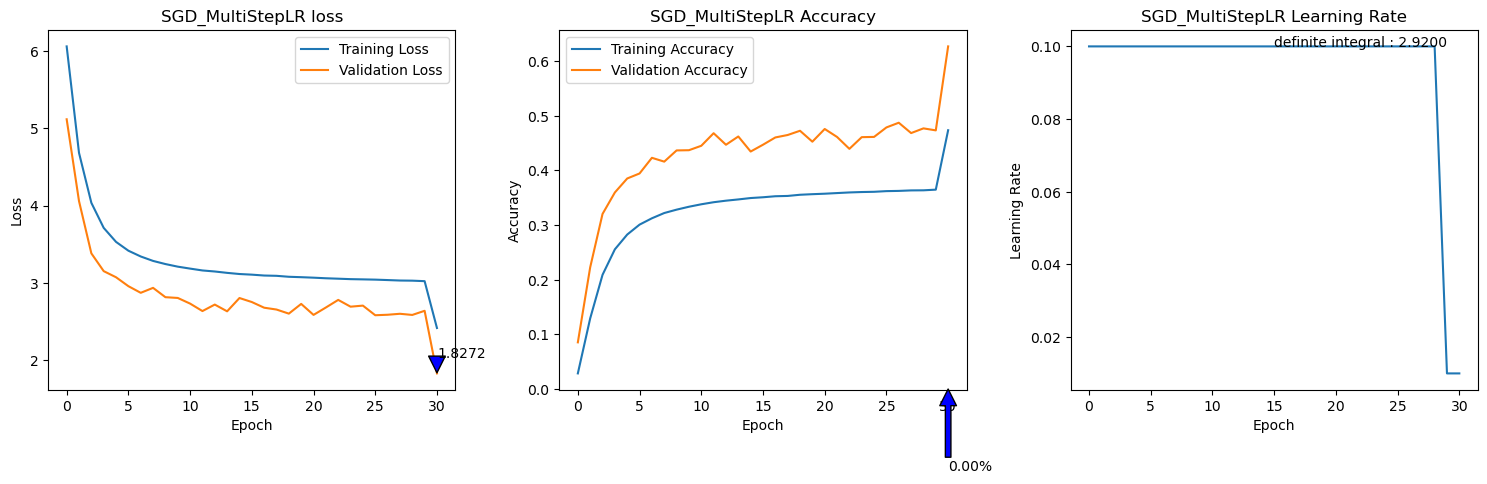

SGD_MultiStepLR
now_lr:  0.010000000000000002
1 epoch: train_loss=6.0621, train_acc=0.0286, valid_loss=5.1182, valid_acc=0.0854, lr=0.1000
2 epoch: train_loss=4.6831, train_acc=0.1292, valid_loss=4.0585, valid_acc=0.2227, lr=0.1000
3 epoch: train_loss=4.0363, train_acc=0.2089, valid_loss=3.3819, valid_acc=0.3203, lr=0.1000
4 epoch: train_loss=3.7119, train_acc=0.2556, valid_loss=3.1517, valid_acc=0.3597, lr=0.1000
5 epoch: train_loss=3.5304, train_acc=0.2826, valid_loss=3.0723, valid_acc=0.3852, lr=0.1000
6 epoch: train_loss=3.4163, train_acc=0.3008, valid_loss=2.9569, valid_acc=0.3944, lr=0.1000
7 epoch: train_loss=3.3415, train_acc=0.3124, valid_loss=2.8709, valid_acc=0.4231, lr=0.1000
8 epoch: train_loss=3.2840, train_acc=0.3220, valid_loss=2.9351, valid_acc=0.4161, lr=0.1000
9 epoch: train_loss=3.2433, train_acc=0.3282, valid_loss=2.8143, valid_acc=0.4366, lr=0.1000
10 epoch: train_loss=3.2097, train_acc=0.3335, valid_loss=2.8044, valid_acc=0.4370, lr=0.1000
11 epoch: train_loss=3.

In [13]:
for training in each_trainings:
    viewer = LogViewer(training.logs)
    viewer.draw(
        title=training.optim_name + "_" + training.scheduler_name,
        min_marker=True,
        save=True,
        add_lr_plot=True,
    )
    print(training.optim_name + "_" + training.scheduler_name)
    if training.scheduler_name == "ReduceLROnPlateau":
        print(training.scheduler.num_bad_epochs)
        print(training.scheduler.cooldown_counter)
        print(training.scheduler.patience)
    
    print("now_lr: ", training.optimizer.param_groups[0]["lr"])
    viewer.print_all()